In [1]:
import gym
import gym_examples
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
env = gym.make('gym_examples/GridWorld-v0', size=4)

# REINFORCE Algorithm

In [2]:
state_size = 16
action_size = 4

In [3]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.softmax(x, dim=-1)

policy = Policy()

In [4]:
def update_policy(rewards, log_probs, optimizer):
    R = 0
    policy_loss = []
    returns = []
    for r in rewards[::-1]:
        R = r + gamma * R
        returns.insert(0, R)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + 1e-9)  # Normalize returns
    for log_prob, R in zip(log_probs, returns):
        policy_loss.append(-log_prob * R)
    optimizer.zero_grad()
    policy_loss = torch.cat(policy_loss).sum()
    policy_loss.backward()
    optimizer.step()


gamma = 0.9


In [5]:
import matplotlib.pyplot as plt

/Users/andyyang/Desktop/DS598 Reinforcement Learning/gym-examples/.env/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Run 1/10 completed.
Run 2/10 completed.
Run 3/10 completed.
Run 4/10 completed.
Run 5/10 completed.
Run 6/10 completed.
Run 7/10 completed.
Run 8/10 completed.
Run 9/10 completed.
Run 10/10 completed.


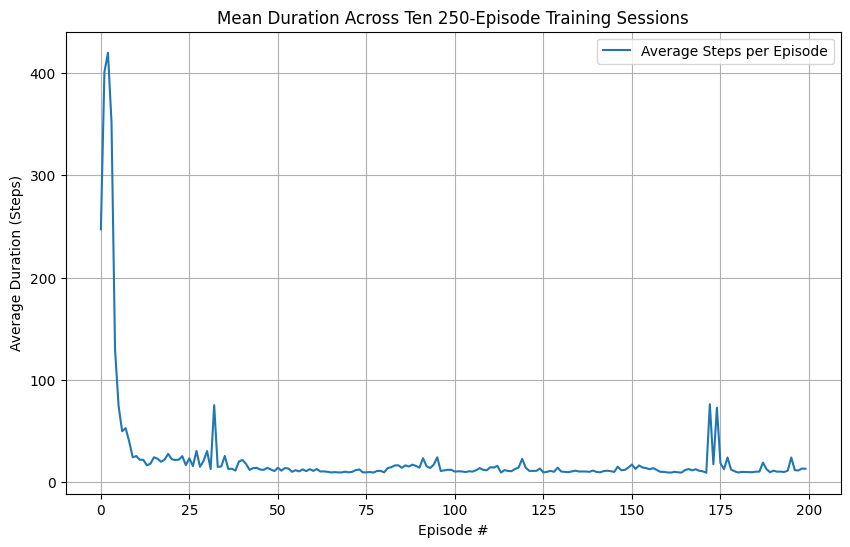

In [6]:
num_runs = 10
num_episodes = 200

# Initialize an array to store the number of steps for all runs
steps_per_episode = np.zeros((num_runs, num_episodes))

for run in range(num_runs):
    env = gym.make('gym_examples/GridWorld-v0', size=4)    
    policy = Policy()  # Reinitialize your policy
    optimizer = optim.Adam(policy.parameters(), lr=0.03)

    for episode in range(num_episodes):
        state = env.reset()[0]['agent']
        done = False

        log_probs = []
        rewards = []
        steps = 0  # Initialize step counter for this episode

        while not done:
            state = torch.tensor(state, dtype=torch.float32).reshape(1, -1)
            probs = policy(state)
            action = torch.multinomial(probs, 1).item()
            log_prob = torch.log(probs[:, action])

            next_state, reward, done, _, _ = env.step(action)
            next_state = next_state['agent']

            rewards.append(reward)
            log_probs.append(log_prob)
            state = next_state
            steps += 1  # Increment step count

        steps_per_episode[run, episode] = steps  # Store the number of steps for this episode
        update_policy(rewards, log_probs, optimizer)  # Update the policy

    print(f"Run {run+1}/{num_runs} completed.")

# Calculate the average number of steps across all runs for each episode
average_steps = np.mean(steps_per_episode, axis=0)

# Plotting the learning curve for steps
plt.figure(figsize=(10, 6))
plt.plot(average_steps, label='Average Steps per Episode')
plt.title("Mean Duration Across Ten 250-Episode Training Sessions")
plt.xlabel("Episode #")
plt.ylabel("Average Duration (Steps)")
plt.legend()
plt.grid(True)
plt.show()

# Plotting with Vstar function as baseline

In [12]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.softmax(self.fc3(x), dim=-1)

policy = Policy()

In [13]:
r = 10
V_star = [r*gamma, r, r*gamma, r*gamma**2,
 r*gamma**6, r*gamma**5, r*gamma**4, r*gamma**3,
 r*gamma**7, r*gamma**6, r*gamma**5, r*gamma**4,
 r*gamma**8, r*gamma**7, r*gamma**6, r*gamma**5]

In [14]:
# V_star = [
#     10, 10*gamma, 10*gamma*2, 10*gamma*3,
#     10*gamma*7, 10*gamma*6, 10*gamma*5, 10*gamma*4,
#     10*gamma*8, 10*gamma*7, 10*gamma*6, 10*gamma*5,
#     10*gamma*9, 10*gamma*8, 10*gamma*7, 10*gamma*6
# ]

In [15]:
def update_policy(policy, rewards, log_probs, states, V_star, optimizer_policy):
    R = 0
    policy_loss = []
    returns = []
    # print(f"STATES: {states}")
    # print(f"REWARDS: {rewards}")
    for r in rewards[::-1]:
        R = r + gamma * R
        returns.insert(0, R)
    returns = torch.tensor(returns)
    
    counter = 0
    for log_prob, R, state in zip(log_probs, returns, states):
        # print(f"iteration: {counter}, log_prob: {log_prob}, return R value: {R}, state: {state}")
        # Subtract the baseline (V*) from the return
        # idx = np.argmax(state)
        baseline = V_star[state]
        advantage = R - baseline
        # advantage = R
        # print(f"R: {R}")
        # print(f"Baseline: {baseline}")
        # print(f"Advantage: {advantage}")
        policy_loss.append(-log_prob * advantage)
    
    optimizer_policy.zero_grad()
    policy_loss = torch.cat(policy_loss).sum()
    policy_loss.backward()
    optimizer_policy.step()


gamma = 0.9



Run 1/1 completed.


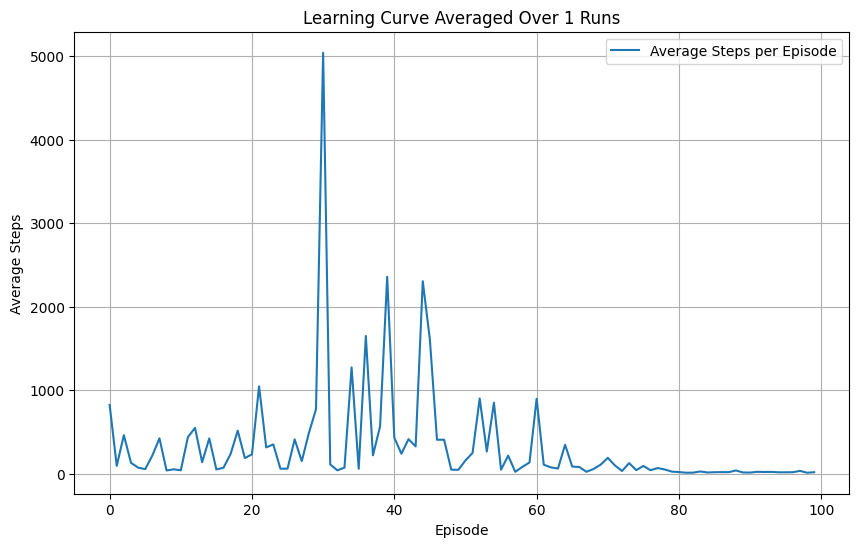

In [16]:
num_runs = 1
num_episodes = 100

# Initialize an array to store the number of steps for all runs
steps_per_episode = np.zeros((num_runs, num_episodes))

for run in range(num_runs):
    env = gym.make('gym_examples/GridWorld-v0', size=4)    
    policy = Policy()  # Reinitialize your policy
    optimizer_policy = optim.Adam(policy.parameters(), lr=0.005)

    for episode in range(num_episodes):
        state = env.reset()[0]['agent']
        done = False

        log_probs = []
        rewards = []
        states = []
        steps = 0  # Initialize step counter for this episode

        while not done:
            # print(f"state: {np.argmax(state)}")
            state_tensor = torch.tensor(state, dtype=torch.float32).reshape(1, -1)
            probs = policy(state_tensor)
            action = torch.multinomial(probs, 1).item()
            log_prob = torch.log(probs[:, action])

            next_state, reward, done, _, _ = env.step(action)
            next_state = next_state['agent']

            rewards.append(reward)
            log_probs.append(log_prob)
            states.append(np.argmax(state))  # Convert state to its index
            state = next_state
            steps += 1
            # print("---")

        steps_per_episode[run, episode] = steps
        # print(f"reached the treasure in {steps} steps. This is episode {episode}, updating policy now")
        update_policy(policy, rewards, log_probs, states, V_star, optimizer_policy)

    print(f"Run {run+1}/{num_runs} completed.")

# Calculate the average number of steps across all runs for each episode
average_steps = np.mean(steps_per_episode, axis=0)

# Plotting the learning curve for steps
plt.figure(figsize=(10, 6))
plt.plot(average_steps, label='Average Steps per Episode')
plt.title("Learning Curve Averaged Over 1 Runs")
plt.xlabel("Episode")
plt.ylabel("Average Steps")
plt.legend()
plt.grid(True)
plt.show()


# Part 3, plotting variance

In [12]:
def compute_gradients(policy, rewards, log_probs, states, V_star=None, gamma=0.9):
    R = 0
    policy_gradients = []
    returns = []
    for r in rewards[::-1]:
        R = r + gamma * R
        returns.insert(0, R)
    returns = torch.tensor(returns, dtype=torch.float32)
    
    for log_prob, R, state in zip(log_probs, returns, states):
        idx = state
        baseline = V_star[idx] if V_star is not None else 0
        advantage = R - baseline
        # advantage = R
        policy_gradients.append(-log_prob * advantage)
    
    return torch.stack(policy_gradients).sum(dim=0)

def empirical_variance(gradients):
    mean_gradient = torch.mean(torch.stack(gradients), dim=0)
    variance = torch.mean((torch.stack(gradients) - mean_gradient)**2)
    return variance.item()

Run 1/1 completed.


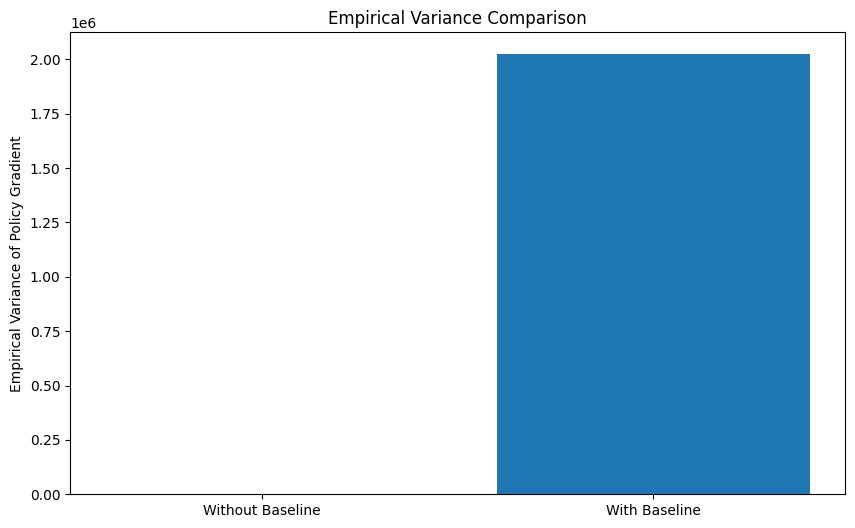

In [13]:
num_runs = 1
num_episodes = 100
gamma = 0.9

# Initialize an array to store the number of steps for all runs
steps_per_episode = np.zeros((num_runs, num_episodes))

# Arrays to store variances
variance_with_baseline = []
variance_without_baseline = []

for run in range(num_runs):
    env = gym.make('gym_examples/GridWorld-v0', size=4)
    policy = Policy()
    optimizer_policy = optim.Adam(policy.parameters(), lr=0.005)

    gradients_with_baseline = []
    gradients_without_baseline = []

    for episode in range(num_episodes):
        state = env.reset()[0]['agent']
        done = False

        log_probs = []
        rewards = []
        states = []
        steps = 0  # Initialize step counter for this episode

        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32).reshape(1, -1)
            probs = policy(state_tensor)
            action = torch.multinomial(probs, 1).item()
            log_prob = torch.log(probs[:, action])

            next_state, reward, done, _, _ = env.step(action)
            next_state = next_state['agent']

            rewards.append(reward)
            log_probs.append(log_prob)
            states.append(np.argmax(state))  # Convert state to its index
            state = next_state
            steps += 1

        steps_per_episode[run, episode] = steps

        # Compute gradients
        gradients_with_baseline.append(compute_gradients(policy, rewards, log_probs, states, V_star))
        gradients_without_baseline.append(compute_gradients(policy, rewards, log_probs, states))

    # Compute empirical variance for the run
    variance_with_baseline.append(empirical_variance(gradients_with_baseline))
    variance_without_baseline.append(empirical_variance(gradients_without_baseline))

    # Use the mean of gradients to update the policy after all episodes
    optimizer_policy.zero_grad()
    mean_gradient_with_baseline = torch.mean(torch.stack(gradients_with_baseline), dim=0)
    mean_gradient_with_baseline.backward()
    optimizer_policy.step()

    print(f"Run {run+1}/{num_runs} completed.")

# Calculate the average number of steps across all runs for each episode
average_steps = np.mean(steps_per_episode, axis=0)

# Calculate the average empirical variances across runs
average_variance_with_baseline = np.mean(variance_with_baseline)
average_variance_without_baseline = np.mean(variance_without_baseline)

# Plotting the empirical variance
plt.figure(figsize=(10, 6))
plt.bar(['Without Baseline', 'With Baseline'], [average_variance_without_baseline, average_variance_with_baseline])
plt.ylabel('Empirical Variance of Policy Gradient')
plt.title("Empirical Variance Comparison")
plt.show()


In [14]:
average_variance_with_baseline

2023375.0

In [15]:
average_variance_without_baseline

6.346653461456299